In [1]:
from scipy import optimize
import scipy.stats as st
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import xarray as xr
import sys
import scipy.io
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import os.path
from os import path
import netCDF4
from statsmodels.tsa.stattools import acf
import netCDF4 as nc
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import norm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import linregress

def weighted_percentile(cli_pr, weights, percentile):
    # Flatten the 2D arrays and remove NaN values
    flat_array = cli_pr.flatten()
    valid_indices = np.logical_not(np.isnan(flat_array))
    sorted_indices = np.argsort(flat_array[valid_indices])
    sorted_array = flat_array[valid_indices][sorted_indices]
    sorted_weights = weights.flatten()[valid_indices][sorted_indices]
    
    # Calculate the cumulative sum of the sorted weights
    cumulative_weights = np.cumsum(sorted_weights)
    total_weight = cumulative_weights[-1]
    
    # Find the index corresponding to the desired percentile
    target_index = np.searchsorted(cumulative_weights, total_weight * (percentile / 100.0))
    
    # Get the value at the target index in the sorted array
    percentile_value = sorted_array[target_index]
    
    return percentile_value


def giniw(x, w=None):
# from https://stackoverflow.com/questions/48999542/more-efficient-weighted-gini-coefficient-in-python
    # The rest of the code requires numpy arrays.
#     x = np.asarray(x)
    if w is not None:
#         w = np.asarray(w)
        sorted_indices = np.argsort(x)
        sorted_x = x[sorted_indices]
        sorted_w = w[sorted_indices]
        # Force float dtype to avoid overflows
        cumw = np.cumsum(sorted_w)
        cumxw = np.cumsum(sorted_x * sorted_w)
        return (np.sum(cumxw[1:] * cumw[:-1] - cumxw[:-1] * cumw[1:]) /
                (cumxw[-1] * cumw[-1]))
    else:
#         x = np.asarray(x)
        sorted_x = np.sort(x)
        n = x.size
        cumx = np.cumsum(sorted_x)
        # The above formula, with all weights equal to 1 simplifies to:
        return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n

    
def find_weighted_percentile_rank(cli_pr, weights, value):
    flat_array = cli_pr.flatten()
    flat_weights = weights.flatten()
    
    # Sort the values and corresponding weights
    sorted_indices = np.argsort(flat_array)
    sorted_array = flat_array[sorted_indices]
    sorted_weights = flat_weights[sorted_indices]
    
    # Calculate the cumulative sum of the sorted weights
    cumulative_weights = np.cumsum(sorted_weights)
    total_weight = cumulative_weights[-1]
    
    # Find the index of the value in the sorted array
    index = np.searchsorted(sorted_array, value)
    
    # Calculate the percentile rank considering weight
    percentile_rank = (cumulative_weights[index] / total_weight) * 100
    
    return percentile_rank

def calculate_mann_kendall(x):
    n = len(x)
    s = 0
    for k in range(n - 1):
        for j in range(k + 1, n):
            s += np.sign(x[j] - x[k])
    trend = s / (n * (n - 1) / 2)
    var_s = (n * (n - 1) * (2 * n + 5)) / 18
    if s > 0:
        z = (s - 1) / np.sqrt(var_s)
    elif s < 0:
        z = (s + 1) / np.sqrt(var_s)
    else:
        z = 0
    p = 2 * (1 - norm.cdf(abs(z)))
    return trend, p

def spa_lag(X, k):

    tree = cKDTree(X)
    spatial_lag = []

    for point in X:
        # Query the k nearest neighbors' indices
        _, indices = tree.query(point, k=k+1)  # +1 to exclude the point itself

        # Calculate the spatial lag by averaging the values of the k nearest neighbors
        spatial_lag_value = np.mean(X[indices[1:], :], axis=0)  # Exclude the first index which is the point itself
        spatial_lag.append(spatial_lag_value)

    spatial_lag = np.array(spatial_lag)
    return spatial_lag



MODELINFO=[["ACCESS-ESM1-5",101,249],\
           ["CanESM5",1850,2000],\
           ["CESM2",1,150],\
           ["EC-Earth3-CC",1850,2000],\
           ["FGOALS-g3",370,525],\
           ["MIROC6",3200,3349],\
           ["MRI-ESM2-0",1850,2000],\
           ["NorESM2-LM",1,150],\
           ["NorESM2-MM",1,150]]
model_names = [model[0] for model in MODELINFO]
model_start = [model[1] for model in MODELINFO]
model_end = [model[2] for model in MODELINFO]
model_names

import xarray as xr
import glob
MODELINFO=[["ACCESS-ESM1-5",101,249],\
           ["CanESM5",1850,2000],\
           ["CESM2",1,150],\
           ["EC-Earth3-CC",1850,2000],\
           ["FGOALS-g3",370,525],\
           ["MIROC6",3200,3349],\
           ["MRI-ESM2-0",1850,2000],\
           ["NorESM2-LM",1,150],\
           ["NorESM2-MM",1,150],\
           ["GFDL-ESM4",1,150],\
           ["CanESM5-1",101,249],\
           ["CAS-ESM2-0",1850,2000],\
           ["CESM2-WACCM",1850,2000],\
           ["CESM2-WACCM-FV2",370,525],\
           ["E3SM-1-0",3200,3349],\
           ["E3SM-2-0",1850,2000],\
           ["E3SM-2-0-NARRM",1850,2000],\
           ["FGOALS-f3-L",1,150],\
           ["GISS-E2-1-G",1,150],\
           ["AWI-CM-1-1-MR",1850,2000]]

GRIDINFO=[["/pr_day_ACCESS-ESM1-5_1pctCO2_r1i1p1f1_gn_01510101-02001231.nc"],\
          ["/pr_day_CanESM5_1pctCO2_r1i1p1f1_gn_18500101-20001231.nc"],\
          ["/pr_day_CESM2_1pctCO2_r1i1p1f1_gn_00710101-00801231.nc"],\
          ["/pr_day_EC-Earth3-CC_1pctCO2_r1i1p1f1_gr_19080101-19081231.nc"],\
          ["/pr_day_FGOALS-g3_1pctCO2_r1i1p1f1_gn_05160101-05161231.nc"],\
          ["/pr_day_MIROC6_1pctCO2_r1i1p1f1_gn_32800101-32891231.nc"],\
          ["/pr_day_MRI-ESM2-0_1pctCO2_r1i1p1f1_gn_18500101-18991231.nc"],\
          ["/pr_day_NorESM2-LM_1pctCO2_r1i1p1f1_gn_01210101-01301231.nc"],\
          ["/pr_day_NorESM2-MM_1pctCO2_r1i1p1f1_gn_01210101-01301231.nc"]]

MASKINFO=[["/mrsos_day_ACCESS-ESM1-5_1pctCO2_r1i1p1f1_gn_01010101-01501231.nc"],\
          ["/mrsos_Lmon_CanESM5_1pctCO2_r1i1p1f1_gn_185001-200012.nc"],\
          ["/mrsos_Lmon_CESM2_1pctCO2_r1i1p1f1_gn_000101-005012.nc"],\
          ["/mrsos_Lmon_EC-Earth3-CC_1pctCO2_r1i1p1f1_gr_199601-199612.nc"],\
          ["/mrsos_Lmon_FGOALS-g3_1pctCO2_r1i1p1f1_gn_037301-052812.nc"],\
          ["/mrsos_Lmon_MIROC6_1pctCO2_r1i1p1f1_gn_320001-329912.nc"],\
          ["/mrsos_Lmon_MRI-ESM2-0_1pctCO2_r1i1p1f1_gn_185001-200012.nc"],\
          ["/mrsos_Lmon_NorESM2-LM_1pctCO2_r1i1p1f1_gn_007101-008012.nc"],\
          ["/mrsos_Lmon_NorESM2-MM_1pctCO2_r1i1p1f1_gn_007101-008012.nc"]]

model_names = [model[0] for model in MODELINFO]
model_start = [model[1] for model in MODELINFO]
model_end = [model[2] for model in MODELINFO]
GRID = [model[0] for model in GRIDINFO]
MASK = [model[0] for model in MASKINFO]
lenyear=100
miss_val = -9.99e08
model_names

['ACCESS-ESM1-5',
 'CanESM5',
 'CESM2',
 'EC-Earth3-CC',
 'FGOALS-g3',
 'MIROC6',
 'MRI-ESM2-0',
 'NorESM2-LM',
 'NorESM2-MM',
 'GFDL-ESM4',
 'CanESM5-1',
 'CAS-ESM2-0',
 'CESM2-WACCM',
 'CESM2-WACCM-FV2',
 'E3SM-1-0',
 'E3SM-2-0',
 'E3SM-2-0-NARRM',
 'FGOALS-f3-L',
 'GISS-E2-1-G',
 'AWI-CM-1-1-MR']

In [2]:
            filename = "/scratch/cimes/hh9736/CMIP6_pr/Spatial_unevenness/"+ timescale[tsl] +"GINI_trend_spa_"+ zone[zo] +""+ surf[sf] +"P_.npy"
            
            arr = np.load(filename)
            arr

NameError: name 'timescale' is not defined

In [3]:
Ttrend=np.zeros(20)
for model in range(0,20):
    filename = f'/scratch/cimes/hh9736/CMIP6_pr/Analysis/Spatial_mean_T_ts_' + model_names[model] + '.npy'
    arr = np.load(filename)
    trend = np.polyfit(np.arange(100), arr[0,0:100], deg=1)
    Ttrend[model] = trend[0]
Ttrend   

array([0.03022803, 0.04348964, 0.03295958, 0.03466202, 0.02333639,
       0.02371682, 0.02516475, 0.02081346, 0.02109053, 0.02589455,
       0.04174125, 0.03144097, 0.03129315, 0.03056553, 0.04865124,
       0.03768503, 0.0362903 , 0.02934327, 0.02717924, 0.03056638])

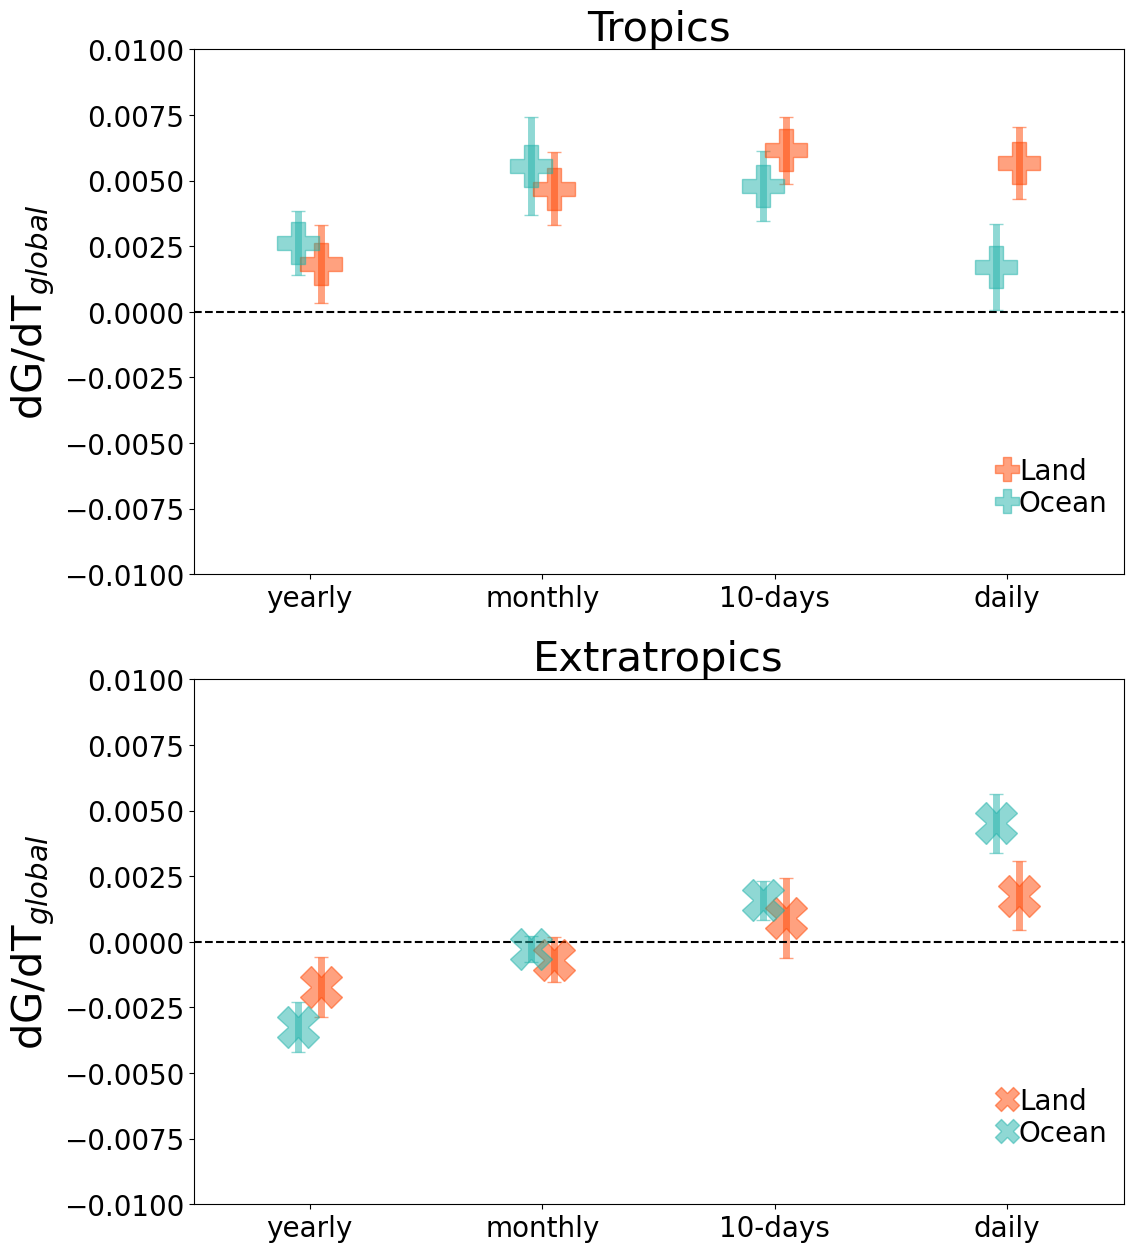

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

colors = ['orangered','lightseagreen','#556B2F']
marker = ["s","X","o"]
markersz = [90,70,50,30]
# Load the data from the file
plt.figure(figsize=(12, 15))

zone = ['30','3090','90']
surf = ['land','ocean','glob']
zonen = ['Tropical','Extratropical','Whole']
surfn = ['land','ocean','globe']
sc = ['yearly','monthly','10-days','daily']
timescale = ['','m','w','d']
tlen = [100,100,100,100]
nm = [20,20,10,10]
plt.subplot(2, 1, 1)
for tsl in range(0,4):
    for sf in range(0,2):
        for zo in range(0,1):
            
            filename = "/scratch/cimes/hh9736/CMIP6_pr/Spatial_unevenness/"+ timescale[tsl] +"GINI_trend_spa_"+ zone[zo] +""+ surf[sf] +"P_.npy"
            
            arr = np.load(filename)
            # Assuming arr is your data with two points
            data2 = arr[0, 0:nm[tsl]]/Ttrend[0:nm[tsl]] 
            data = arr[1, 0:nm[tsl]]
            t_statistic, p_value = stats.ttest_1samp(data2, 0)
          

            # Calculate the mean and standard deviation
            mean2 = np.mean(data2)
            std_dev2 = np.std(data2)
            confidence_level = 0.95  # You can adjust this as needed
            ci = stats.norm.interval(confidence_level, loc=mean2, scale=std_dev2/np.sqrt(len(data2)))

            # Calculate the standard error (assuming two data points)
            alpha_value = 0.5

           # bp = plt.boxplot(data2, vert=True, positions=[tsl+1+((-1)**sf)*0.05],patch_artist=True, boxprops=dict(facecolor=colors[sf], alpha=0.5, linewidth=2.0, edgecolor=colors[sf]), widths=[0.1], flierprops=dict(marker='o', markerfacecolor=colors[sf], markersize=8, alpha=1))

#            for element in ['whiskers', 'medians', 'caps']:
 #               plt.setp(bp[element], color=colors[sf], linewidth=4.0)
            plt.errorbar(tsl+1+((-1)**sf)*0.05, mean2, yerr=np.array([mean2 - ci[0], ci[1] - mean2]).reshape(2, 1), fmt='P', markersize=30, ecolor=colors[sf], capsize=5, elinewidth=(5), label='Data Point', color=colors[sf],alpha=alpha_value)
        
            # Add labels to the axes
plt.ylabel('dG/dT$_{global}$', fontsize=30)
plt.axhline(0, color='black', linestyle='--', label='y=0')
plt.xticks(fontsize=20) 
plt.yticks(fontsize=20) 
plt.xlim(0.5, 4.5)  # Set the x-axis range from 0 to 4
plt.ylim(-0.01, 0.01)  # Set the y-axis range from -3 to 3
plt.title("Tropics", fontsize=30)
plt.xticks([])
x_positions = [1, 2, 3, 4]
plt.xticks(x_positions, sc)
plt.scatter(4,-0.015*0.4,s=300,marker='P',color=colors[0] ,alpha=0.5)
plt.text(4.05, -0.016*0.4, 'Land', fontsize=20)
plt.scatter(4,-0.018*0.4,s=300,marker='P',color=colors[1] ,alpha=0.5)
plt.text(4.05, -0.019*0.4, 'Ocean', fontsize=20)

plt.subplot(2, 1, 2)

for tsl in range(0,4):
    for sf in range(0,2):
        for zo in range(1,2):
            filename = "/scratch/cimes/hh9736/CMIP6_pr/Spatial_unevenness/"+ timescale[tsl] +"GINI_trend_spa_"+ zone[zo] +""+ surf[sf] +"P_.npy"
            arr = np.load(filename)

            # Assuming arr is your data with two points
            data2 = arr[0, 0:nm[tsl]]/Ttrend[0:nm[tsl]] 
            data = arr[1, 0:nm[tsl]]
            t_statistic, p_value = stats.ttest_1samp(data2, 0)
          

            # Calculate the mean and standard deviation
            mean2 = np.mean(data2)
            std_dev2 = np.std(data2)
            confidence_level = 0.95  # You can adjust this as needed
            ci = stats.norm.interval(confidence_level, loc=mean2, scale=std_dev2/np.sqrt(len(data2)))

            # Calculate the standard error (assuming two data points)
            alpha_value = 0.5

           # bp = plt.boxplot(data2, vert=True, positions=[tsl+1+((-1)**sf)*0.05],patch_artist=True, boxprops=dict(facecolor=colors[sf], alpha=0.5, linewidth=2.0, edgecolor=colors[sf]), widths=[0.1], flierprops=dict(marker='o', markerfacecolor=colors[sf], markersize=8, alpha=1))

#            for element in ['whiskers', 'medians', 'caps']:
 #               plt.setp(bp[element], color=colors[sf], linewidth=4.0)
            plt.errorbar(tsl+1+((-1)**sf)*0.05, mean2, yerr=np.array([mean2 - ci[0], ci[1] - mean2]).reshape(2, 1), fmt='X', markersize=30, ecolor=colors[sf], capsize=5, elinewidth=(5), label='Data Point', color=colors[sf],alpha=alpha_value)
        
            # Add labels to the axes
plt.ylabel('dG/dT$_{global}$', fontsize=30)
plt.axhline(0, color='black', linestyle='--', label='y=0')
plt.xticks(fontsize=20) 
plt.yticks(fontsize=20) 
plt.xlim(0.5, 4.5)  # Set the x-axis range from 0 to 4
plt.ylim(-0.01, 0.01)  # Set the y-axis range from -3 to 3
plt.title("Extratropics", fontsize=30)
plt.xticks([])
x_positions = [1, 2, 3, 4]
plt.xticks(x_positions, sc)
plt.scatter(4,-0.015*0.4,s=300,marker='X',color=colors[0] ,alpha=0.5)
plt.text(4.05, -0.016*0.4, 'Land', fontsize=20)
plt.scatter(4,-0.018*0.4,s=300,marker='X',color=colors[1] ,alpha=0.5)
plt.text(4.05, -0.019*0.4, 'Ocean', fontsize=20)
plt.savefig("Figures/GINI_trend_sig_all_scale_errorbarchart_Normalized.png", format="png", bbox_inches="tight")   

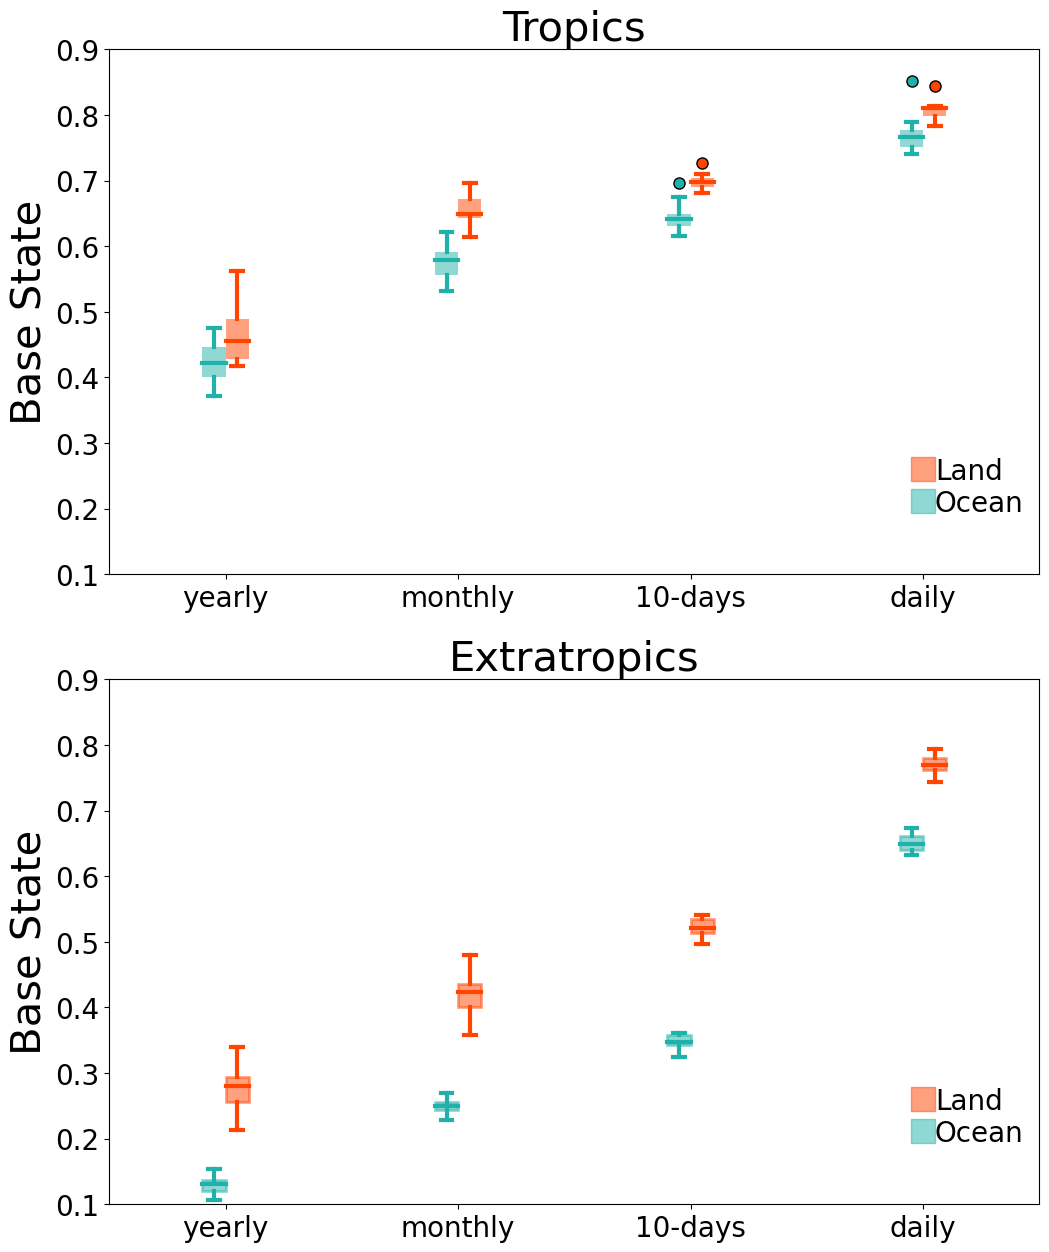

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

colors = ['orangered','lightseagreen','#556B2F']
marker = ["s","X","o"]
markersz = [90,70,50,30]
# Load the data from the file
plt.figure(figsize=(12, 15))

zone = ['30','3090','90']
surf = ['land','ocean','glob']
zonen = ['Tropical','Extratropical','Whole']
surfn = ['land','ocean','globe']
sc = ['yearly','monthly','10-days','daily']
timescale = ['','m','w','d']
tlen = [100,1200,3650,36500]
nm = [20,20,10,10]
plt.subplot(2, 1, 1)
for tsl in range(0,4):
    for sf in range(0,2):
        for zo in range(0,1):
           
            filename = "/scratch/cimes/hh9736/CMIP6_pr/Spatial_unevenness/"+ timescale[tsl] +"GINI_trend_spa_"+ zone[zo] +""+ surf[sf] +"P_.npy"
            arr = np.load(filename)

            # Assuming arr is your data with two points
            data2 = arr[1, 0:nm[tsl]]
            t_statistic, p_value = stats.ttest_1samp(data2, 0)
          

            # Calculate the mean and standard deviation
            mean2 = np.mean(data2)
            std_dev2 = np.std(data2)
            confidence_level = 0.95  # You can adjust this as needed
            ci = stats.norm.interval(confidence_level, loc=mean2, scale=std_dev2/np.sqrt(len(data2)))

            # Calculate the standard error (assuming two data points)
            alpha_value = 0.5

            bp = plt.boxplot(data2, vert=True, positions=[tsl+1+((-1)**sf)*0.05],patch_artist=True, boxprops=dict(facecolor=colors[sf], alpha=0.5, linewidth=.0, edgecolor=colors[sf]), widths=[0.1], flierprops=dict(marker='o', markerfacecolor=colors[sf], markersize=8, alpha=1))

            for element in ['whiskers', 'medians', 'caps']:
                plt.setp(bp[element], color=colors[sf], linewidth=3.0)
           # plt.errorbar(tsl+1+((-1)**sf)*0.05, mean2, yerr=np.array([mean2 - ci[0], ci[1] - mean2]).reshape(2, 1), fmt='X', markersize=30, ecolor=colors[sf], capsize=5, elinewidth=(5), label='Data Point', color=colors[sf],alpha=alpha_value)
        
            # Add labels to the axes
plt.ylabel('Base State', fontsize=30)
plt.axhline(0, color='black', linestyle='--', label='y=0')
plt.xticks(fontsize=20) 
plt.yticks(fontsize=20) 
plt.xlim(0.5, 4.5)  # Set the x-axis range from 0 to 4
plt.ylim(0.1, 0.9)  # Set the y-axis range from -3 to 3
plt.title("Tropics", fontsize=30)
plt.xticks([])
x_positions = [1, 2, 3, 4]
plt.xticks(x_positions, sc)
plt.scatter(4, 0.8/0.05*(-0.015+0.025)+.1,s=300,marker='s',color=colors[0] ,alpha=0.5)
plt.text(4.05,0.8/0.05*(-0.016+0.025)+.1, 'Land', fontsize=20)
plt.scatter(4,0.8/0.05*(-0.018+0.025)+.1,s=300,marker='s',color=colors[1] ,alpha=0.5)
plt.text(4.05, 0.8/0.05*(-0.019+0.025)+.1, 'Ocean', fontsize=20)

plt.subplot(2, 1, 2)

for tsl in range(0,4):
    for sf in range(0,2):
        for zo in range(1,2):
            filename = "/scratch/cimes/hh9736/CMIP6_pr/Spatial_unevenness/"+ timescale[tsl] +"GINI_trend_spa_"+ zone[zo] +""+ surf[sf] +"P_.npy"
            arr = np.load(filename)

            # Assuming arr is your data with two points
            data2 = arr[1, 0:nm[tsl]]
            t_statistic, p_value = stats.ttest_1samp(data2, 0)
          

            # Calculate the mean and standard deviation
            mean2 = np.mean(data2)
            std_dev2 = np.std(data2)
            confidence_level = 0.95  # You can adjust this as needed
            ci = stats.norm.interval(confidence_level, loc=mean2, scale=std_dev2/np.sqrt(len(data2)))

            # Calculate the standard error (assuming two data points)
            alpha_value = 0.5

            bp = plt.boxplot(data2, vert=True, positions=[tsl+1+((-1)**sf)*0.05],patch_artist=True, boxprops=dict(facecolor=colors[sf], alpha=0.5, linewidth=2.0, edgecolor=colors[sf]), widths=[0.1], flierprops=dict(marker='o', markerfacecolor=colors[sf], markersize=8, alpha=1))

            for element in ['whiskers', 'medians', 'caps']:
                plt.setp(bp[element], color=colors[sf], linewidth=3.0)
            #plt.errorbar(tsl+1+((-1)**sf)*0.05, mean2, yerr=np.array([mean2 - ci[0], ci[1] - mean2]).reshape(2, 1), fmt='X', markersize=30, ecolor=colors[sf], capsize=5, elinewidth=(5), label='Data Point', color=colors[sf],alpha=alpha_value)
        
            # Add labels to the axes
plt.ylabel('Base State', fontsize=30)
plt.axhline(0, color='black', linestyle='--', label='y=0')
plt.xticks(fontsize=20) 
plt.yticks(fontsize=20) 
plt.xlim(0.5, 4.5)  # Set the x-axis range from 0 to 4
plt.ylim(0.1, 0.9)  # Set the y-axis range from -3 to 3
plt.title("Extratropics", fontsize=30)
plt.xticks([])
x_positions = [1, 2, 3, 4]
plt.xticks(x_positions, sc)
plt.scatter(4, 0.8/0.05*(-0.015+0.025)+.1,s=300,marker='s',color=colors[0] ,alpha=0.5)
plt.text(4.05,0.8/0.05*(-0.016+0.025)+.1, 'Land', fontsize=20)
plt.scatter(4,0.8/0.05*(-0.018+0.025)+.1,s=300,marker='s',color=colors[1] ,alpha=0.5)
plt.text(4.05, 0.8/0.05*(-0.019+0.025)+.1, 'Ocean', fontsize=20)
plt.savefig("Figures/GINI_basestate_sig_all_scale_boxchart.png", format="png", bbox_inches="tight")   